# Content

*    ### [Setup ](#SETUP)
*    ### [Question 1](#Q1)
*    ### [Question 2](#Q2)
*    ### [Question 3](#Q3)

*    ### [Discussion](#Discuss)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# <a name="SETUP">Setup</a>

In [ ]:
# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers,Sequential

from keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.layers import Normalization, StringLookup, IntegerLookup
from keras.models import load_model
from keras.layers import Embedding,Flatten
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/hdb_price_prediction.csv')
df.head()

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0


In [ ]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    #dataframe = dataframe.drop(columns=['year', 'full_address','nearest_stn'])
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


In [ ]:
# Metric to calculate R2
# Add r2_score metric in each training epoch
def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# <a name="Q1">Question 1</a>

## Question 1 Part A

In [ ]:


#Split data
train_dataframe = df[df['year'] <= 2020] # 0.8393471285568813
val_dataframe = df[df['year'] > 2020]

train_dataframe=train_dataframe.drop(columns=['year', 'full_address', 'nearest_stn'])
val_dataframe=val_dataframe.drop(columns=['year', 'full_address', 'nearest_stn'])

train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

train_ds = train_ds.batch(128)
val_ds = val_ds.batch(128)



Comment:

The purpose of training suh a model is to predict future housing prices. Instead of random train test splits, splitting by year would give more confidence to the predictions of model e.g. housing prices in 2022 and above.

## Question 1 Part B

In [ ]:
# Categorical features encoded as integers
month = keras.Input(shape=(1,), name="month", dtype="int64")
month_encoded = encode_categorical_feature(month, "month", train_ds, False)

# Categorical feature encoded as string
flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
flat_model_type_encoded = encode_categorical_feature(flat_model_type, "flat_model_type", train_ds, True)

storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")
storey_range_encoded = encode_categorical_feature(storey_range, "storey_range", train_ds, True)

# Numerical features
floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)

dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)

dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)

degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)

eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)

remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)
 
all_inputs = [
    month,
    flat_model_type,
    storey_range,
    floor_area_sqm,
    dist_to_nearest_stn,
    dist_to_dhoby,
    degree_centrality,
    eigenvector_centrality,
    remaining_lease_years
]


all_features = layers.concatenate(
    [
        month_encoded,
        flat_model_type_encoded,
        storey_range_encoded,
        floor_area_sqm_encoded,
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        remaining_lease_years_encoded


    ]
)
# feedforward network with one hidden layer
x = layers.Dense(10, activation="relu")(all_features)
output = layers.Dense(1, activation="linear")(x)
encoded_model = keras.Model(all_inputs, output)

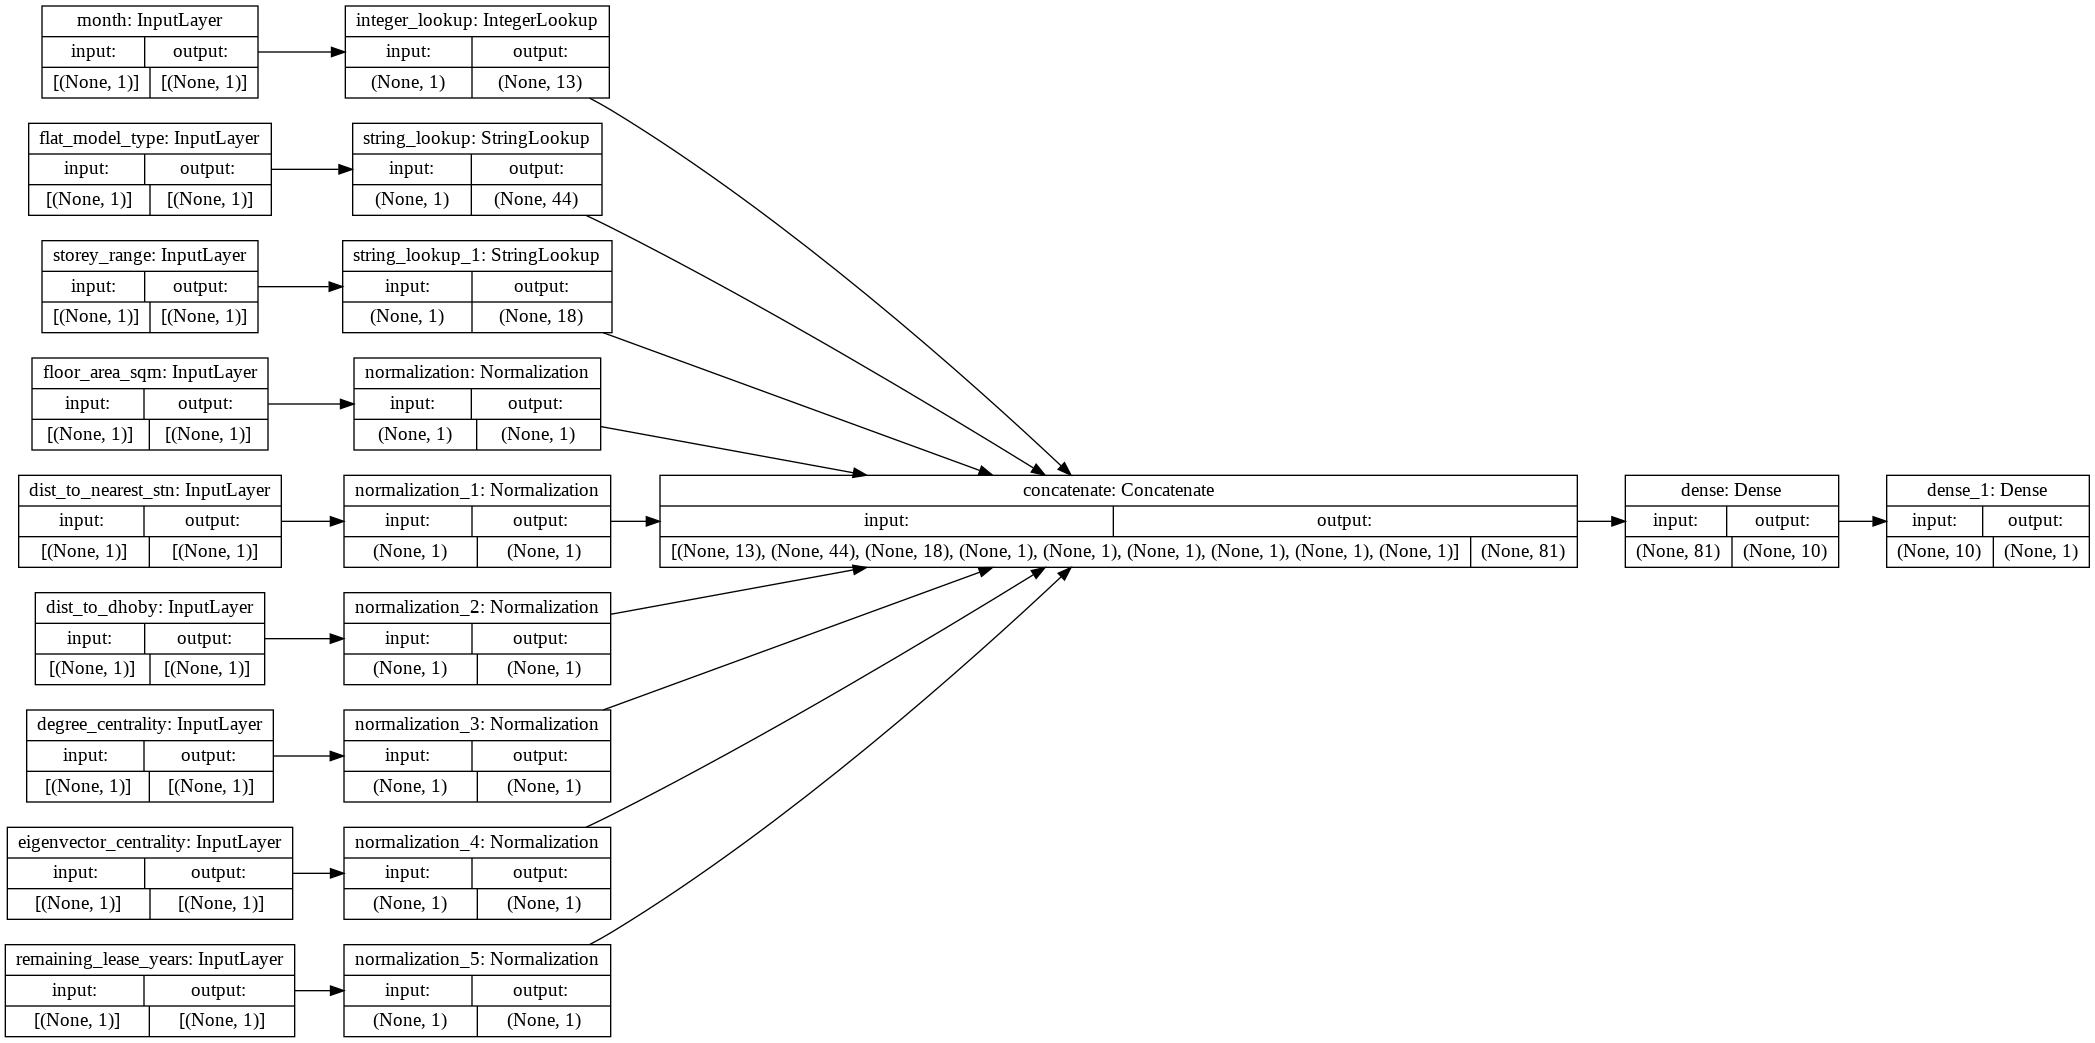

In [ ]:
keras.utils.plot_model(encoded_model, show_shapes=True, rankdir="LR", to_file='encoded.png')

## Question 1 Part C

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.05)
encoded_model.compile(optimizer=opt, loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError(),r2_score])

filepath ='best_model.ckpt' 

# Checkpoint for minimum val_loss
mc = ModelCheckpoint(filepath , monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = encoded_model.fit(
    train_ds,batch_size=128, epochs=100, verbose=1,validation_data=val_ds, callbacks=[mc]
)
keras.backend.clear_session()

Epoch 1/100
683/683 [==============================] - 4s 4ms/step - loss: 187146420224.0000 - root_mean_squared_error: 432604.2188 - r2_score: -7.0476 - val_loss: 170723508224.0000 - val_root_mean_squared_error: 413187.0000 - val_r2_score: -5.6982

Epoch 00001: val_loss improved from inf to 170723508224.00000, saving model to best_model.ckpt
INFO:tensorflow:Assets written to: best_model.ckpt/assets
Epoch 2/100
683/683 [==============================] - 3s 4ms/step - loss: 67277107200.0000 - root_mean_squared_error: 259378.3125 - r2_score: -1.8836 - val_loss: 39922339840.0000 - val_root_mean_squared_error: 199805.7500 - val_r2_score: -0.5543

Epoch 00002: val_loss improved from 170723508224.00000 to 39922339840.00000, saving model to best_model.ckpt
INFO:tensorflow:Assets written to: best_model.ckpt/assets
Epoch 3/100
683/683 [==============================] - 3s 4ms/step - loss: 10876963840.0000 - root_mean_squared_error: 104292.6797 - r2_score: 0.5391 - val_loss: 11052743680.0000 - v

## Question 1 Part D

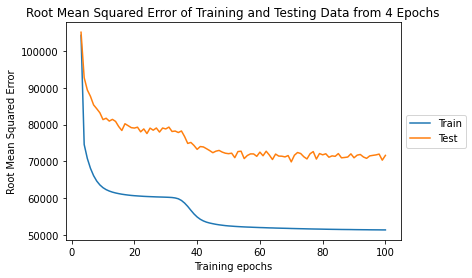

In [ ]:
# Drop first 3 is enough
plt.plot(range(3,101),history.history['root_mean_squared_error'][2:])
plt.plot(range(3,101),history.history['val_root_mean_squared_error'][2:])
plt.title('Root Mean Squared Error of Training and Testing Data from 4 Epochs')
plt.ylabel('Root Mean Squared Error')
plt.xlabel('Training epochs')
plt.legend(['Train', 'Test'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Question 1 Part E

In [ ]:
history.history['val_loss'].index(min(history.history['val_loss']))

69

In [ ]:
history.history['val_r2_score'][history.history['val_loss'].index(min(history.history['val_loss']))]

0.8084256052970886

Comment:

The epoch with the lowest test error is 70 (add 1 because of list index). Test R2 value at that epoch is 0.8084

## Question 1 Part F

In [ ]:
# random select 128 samples from dataset
batch_number=val_ds.cardinality().numpy()
temp_val_ds= val_ds.shuffle(batch_number, reshuffle_each_iteration=False)
one_batch_test_ds=temp_val_ds.take(1)

In [ ]:
# Load the model
encoded_model.load_weights(filepath)
predictions = encoded_model.predict(one_batch_test_ds)
keras.backend.clear_session()

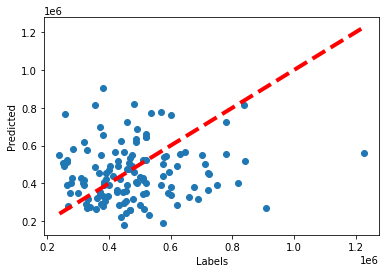

In [ ]:
y = np.concatenate([y for x, y in one_batch_test_ds], axis=0).reshape(128,1)
fig, ax = plt.subplots()
ax.scatter(y, predictions)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4,color='r')
ax.set_xlabel('Labels')
ax.set_ylabel('Predicted')
plt.show()

# <a name="Q2">Question 2</a>

## Question 2 Part A and Part B

In [ ]:
def embedded_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="int") 

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)

    # Get number of categories in a feature
    num_categories = len(lookup.get_vocabulary(include_special_tokens=False))
    input_dim = len(lookup.get_vocabulary(include_special_tokens=True))

    # Create embedding layer
    embedded_feature = keras.layers.Embedding(input_dim, int(np.floor(num_categories/2)))(encoded_feature)

    return embedded_feature

  

In [ ]:
def create_embeded_model(train_ds):
 


  # Categorical features encoded as integers
  month = keras.Input(shape=(1,), name="month", dtype="int64")
  month_embedded = embedded_categorical_feature(month, "month", train_ds, False)
  month_embedded = Flatten()(month_embedded)


  # Categorical feature encoded as string
  flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
  flat_model_type_embedded = embedded_categorical_feature(flat_model_type, "flat_model_type", train_ds, True)
  flat_model_type_embedded = Flatten()(flat_model_type_embedded)

  storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")
  storey_range_embedded = embedded_categorical_feature(storey_range, "storey_range", train_ds, True)
  storey_range_embedded = Flatten()(storey_range_embedded)

  # Numerical features
  floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")
  floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)

  dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
  dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)

  dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
  dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)

  degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
  degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)

  eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
  eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)

  remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
  remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)
  
  all_inputs = [
      month,
      flat_model_type,
      storey_range,
      floor_area_sqm,
      dist_to_nearest_stn,
      dist_to_dhoby,
      degree_centrality,
      eigenvector_centrality,
      remaining_lease_years
  ]

  all_features = layers.concatenate(
    [
        # Categorical Features
        month_embedded,
        
        storey_range_embedded,
        flat_model_type_embedded,
                    
        # Numerical Features
        floor_area_sqm_encoded,
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        remaining_lease_years_encoded


    ]
  )

  # feedforward network with one hidden layer
  x = layers.Dense(10, activation="relu")(all_features)
  output = layers.Dense(1, activation="linear")(x)
  embedded_model = keras.Model(all_inputs, output)
  return embedded_model

In [ ]:
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
embedded_model=create_embeded_model(train_ds)


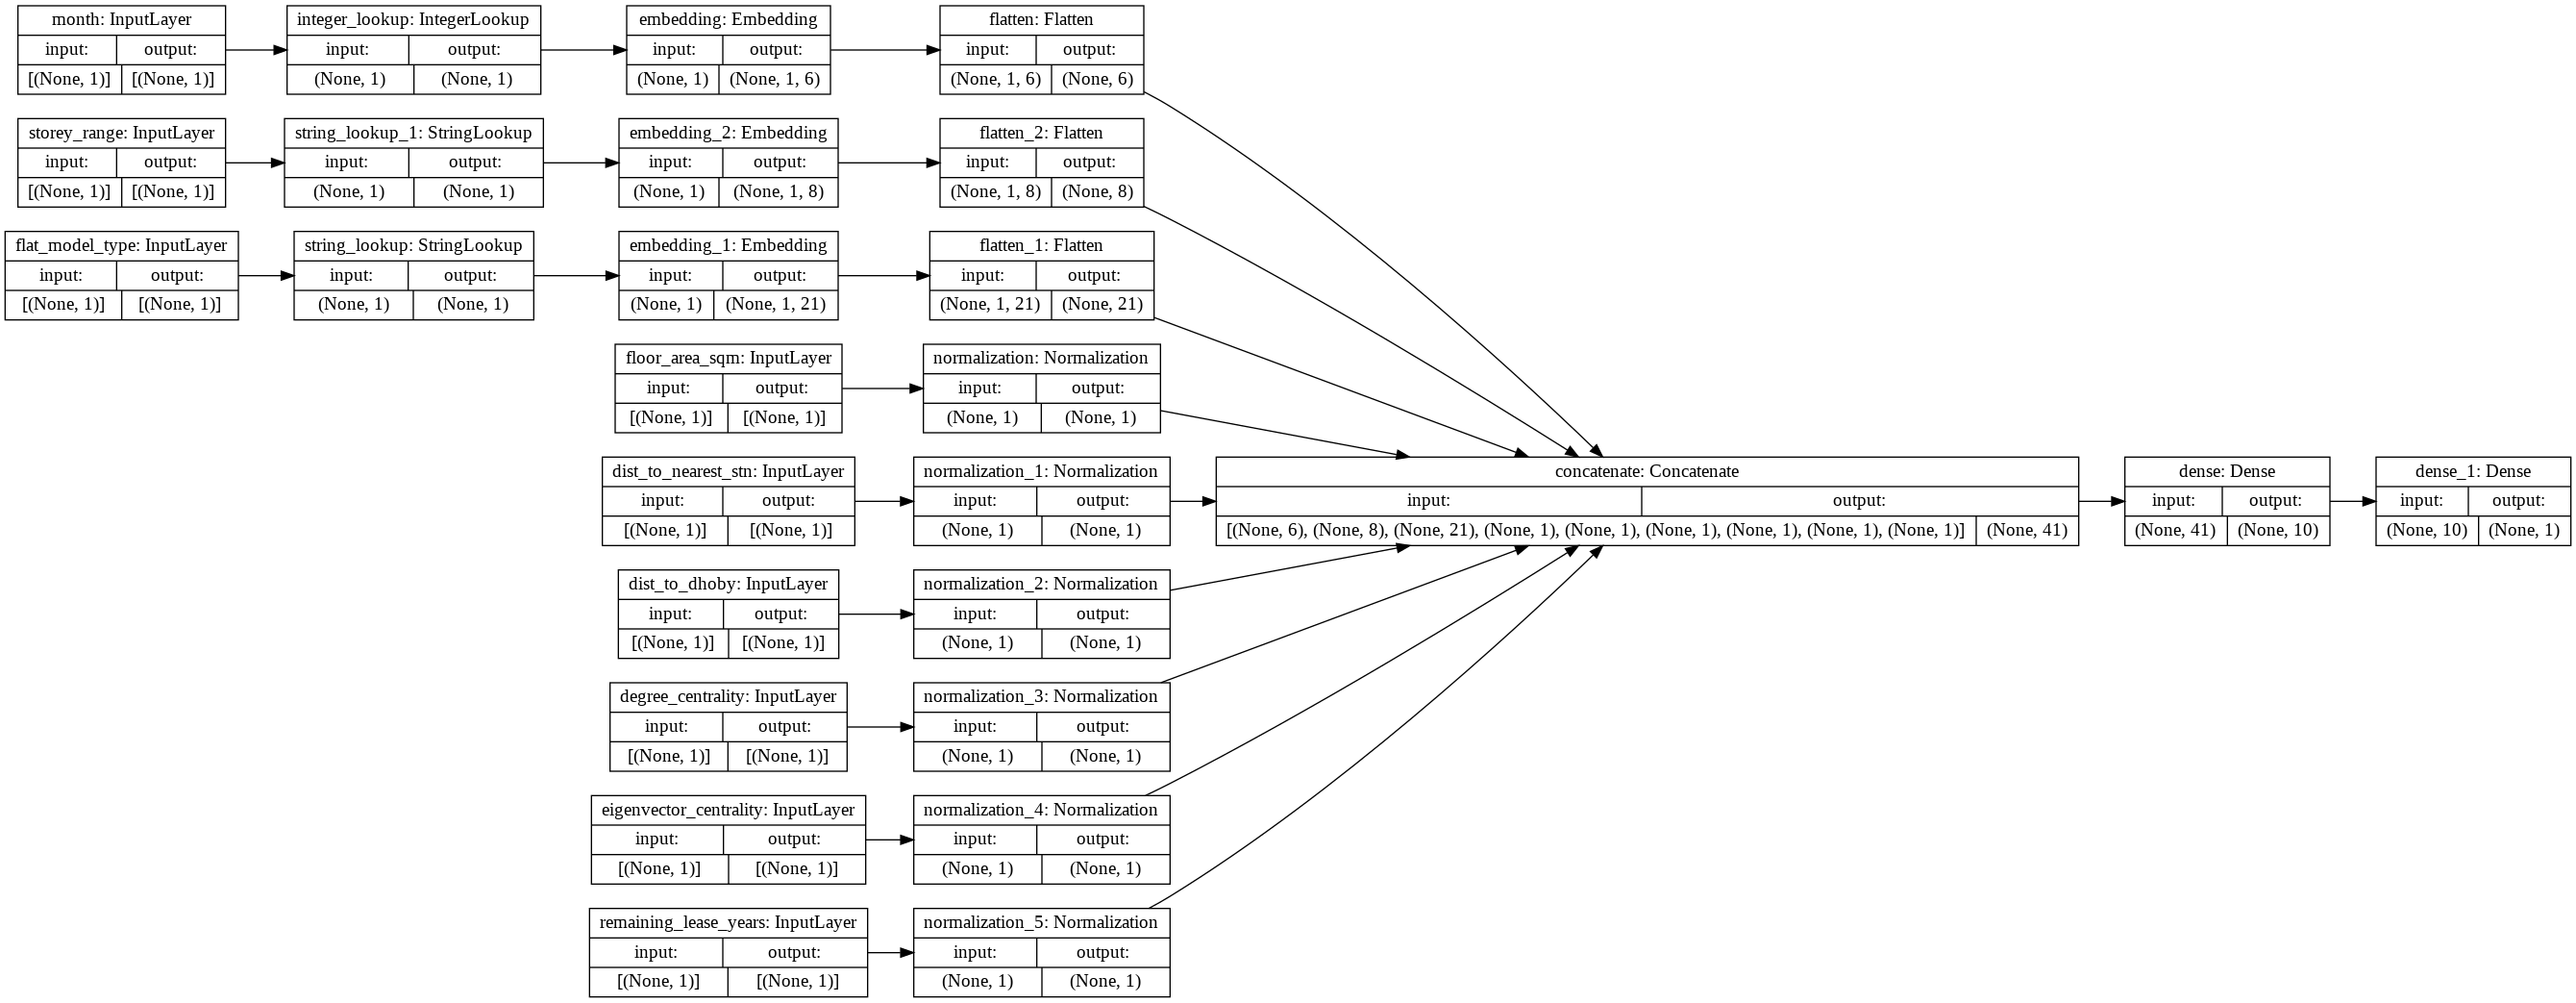

In [ ]:
keras.utils.plot_model(embedded_model, show_shapes=True, rankdir="LR", to_file='embeddings.png')

In [ ]:

opt = keras.optimizers.Adam(learning_rate=0.05)
embedded_model.compile(optimizer=opt, loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError(),r2_score])
history_embedded = embedded_model.fit(
    train_ds,batch_size=128, epochs=100, verbose=1,validation_data=val_ds
)
keras.backend.clear_session()

Epoch 1/100
683/683 [==============================] - 4s 4ms/step - loss: 46405177344.0000 - root_mean_squared_error: 215418.6094 - r2_score: -0.9985 - val_loss: 11945663488.0000 - val_root_mean_squared_error: 109296.2188 - val_r2_score: 0.5408
Epoch 2/100
683/683 [==============================] - 3s 4ms/step - loss: 8078336000.0000 - root_mean_squared_error: 89879.5625 - r2_score: 0.6549 - val_loss: 9833835520.0000 - val_root_mean_squared_error: 99165.6953 - val_r2_score: 0.6196
Epoch 3/100
683/683 [==============================] - 3s 4ms/step - loss: 7013317632.0000 - root_mean_squared_error: 83745.5547 - r2_score: 0.7000 - val_loss: 8869251072.0000 - val_root_mean_squared_error: 94176.7031 - val_r2_score: 0.6562
Epoch 4/100
683/683 [==============================] - 3s 4ms/step - loss: 6261925376.0000 - root_mean_squared_error: 79132.3281 - r2_score: 0.7319 - val_loss: 8415464448.0000 - val_root_mean_squared_error: 91735.8438 - val_r2_score: 0.6740
Epoch 5/100
683/683 [==========

## Question 2 Part C

In [ ]:
history_embedded.history['val_loss'].index(min(history_embedded.history['val_loss']))


97

In [ ]:
min(history_embedded.history['val_loss'])

4857675264.0

In [ ]:
history_embedded.history['val_loss'].index(min(history_embedded.history['val_loss']))


97

In [ ]:
min(history_embedded.history['val_loss'])

4857675264.0

In [ ]:
history_embedded.history['val_r2_score'][history_embedded.history['val_loss'].index(min(history_embedded.history['val_loss']))]

0.8101443648338318

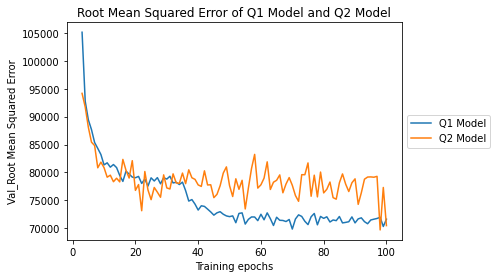

In [ ]:
# Drop first 3 is enough
plt.plot(range(3,101),history.history['val_root_mean_squared_error'][2:])
plt.plot(range(3,101),history_embedded.history['val_root_mean_squared_error'][2:])
plt.title('Root Mean Squared Error of Q1 Model and Q2 Model')
plt.ylabel('Val_Root Mean Squared Error')
plt.xlabel('Training epochs')
plt.legend(['Q1 Model', 'Q2 Model'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Comment:

*  Q1 model's best epoch (with the lowest test error) is 70. Test R2 value at that epoch is 0.8084.

*  Q2 model's best epoch (with the lowest test error) is 96. Test R2 value at that epoch is 0.8146.

*  Q1 model performs slightly better may because of Q1 model using one-hot encoded which more neurons and parameters being used.



# <a name="Q3">Question 3</a>

## Question 3 Part A

In [ ]:

def create_embedded_model(features,train_ds):
  # Model with Embedded Layer architecture Layers
  # Do not modify 
  # Categorical features encoded as integers
  month = keras.Input(shape=(1,), name="month", dtype="int64")
  month_embedded = embedded_categorical_feature(month, "month", train_ds, False)
  month_embedded = Flatten()(month_embedded)


  # Categorical feature encoded as string
  flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
  flat_model_type_embedded = embedded_categorical_feature(flat_model_type, "flat_model_type", train_ds, True)
  flat_model_type_embedded = Flatten()(flat_model_type_embedded)


  storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")
  storey_range_embedded = embedded_categorical_feature(storey_range, "storey_range", train_ds, True)
  storey_range_embedded = Flatten()(storey_range_embedded)

  # Numerical features
  floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")
  floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)

  dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
  dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)

  dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
  dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)

  degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
  degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)

  eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
  eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)

  remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
  remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)

  features_input_dictionary={
        'month':month,
        'flat_model_type':flat_model_type,
        'storey_range':storey_range,
        'floor_area_sqm':floor_area_sqm,
        'dist_to_nearest_stn':dist_to_nearest_stn,
        'dist_to_dhoby':dist_to_dhoby,
        'degree_centrality':degree_centrality,
        'eigenvector_centrality':eigenvector_centrality,
        'remaining_lease_years':remaining_lease_years
  }
  
  features_layers_dictionary={
        'month':month_embedded,
        'flat_model_type':flat_model_type_embedded,
        'storey_range':storey_range_embedded,
        'floor_area_sqm':floor_area_sqm_encoded,
        'dist_to_nearest_stn':dist_to_nearest_stn_encoded,
        'dist_to_dhoby':dist_to_dhoby_encoded,
        'degree_centrality':degree_centrality_encoded,
        'eigenvector_centrality':eigenvector_centrality_encoded,
        'remaining_lease_years':remaining_lease_years_encoded
  }

  all_inputs= [features_input_dictionary[x] for x in features]

  all_features = layers.concatenate(
    [features_layers_dictionary[x] for x in features]
  )
  
  
  # feedforward network with one hidden layer
  x = layers.Dense(10, activation="relu")(all_features)
  output = layers.Dense(1, activation="linear")(x)

  created_model = keras.Model(all_inputs, output)
  
  return created_model


In [ ]:
features= ['month','flat_model_type','storey_range','floor_area_sqm','dist_to_nearest_stn','dist_to_dhoby','degree_centrality','eigenvector_centrality','remaining_lease_years']
# Set seed again
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
full_features_model=create_embedded_model(features,train_ds)

opt = keras.optimizers.Adam(learning_rate=0.05)

full_features_model.compile(optimizer=opt, loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError(),r2_score])
 

es= EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

orig_history = full_features_model.fit(
    train_ds,batch_size=128, epochs=100, verbose=1,validation_data=val_ds, callbacks=[es]
)

keras.backend.clear_session()


Epoch 1/100
683/683 [==============================] - 4s 4ms/step - loss: 46734749696.0000 - root_mean_squared_error: 216182.2188 - r2_score: -1.0098 - val_loss: 11977466880.0000 - val_root_mean_squared_error: 109441.6172 - val_r2_score: 0.5393
Epoch 2/100
683/683 [==============================] - 3s 4ms/step - loss: 8053400064.0000 - root_mean_squared_error: 89740.7344 - r2_score: 0.6552 - val_loss: 10198036480.0000 - val_root_mean_squared_error: 100985.3281 - val_r2_score: 0.6046
Epoch 3/100
683/683 [==============================] - 3s 4ms/step - loss: 7009763840.0000 - root_mean_squared_error: 83724.3359 - r2_score: 0.7001 - val_loss: 9287971840.0000 - val_root_mean_squared_error: 96374.1250 - val_r2_score: 0.6415
Epoch 4/100
683/683 [==============================] - 3s 4ms/step - loss: 6252270592.0000 - root_mean_squared_error: 79071.2969 - r2_score: 0.7319 - val_loss: 8292428288.0000 - val_root_mean_squared_error: 91062.7734 - val_r2_score: 0.6782
Epoch 5/100
683/683 [========

In [ ]:
# Do not modify the value
min_full_features_MSE=min(orig_history.history['val_loss'])
# Keep track of its performance
min_index=orig_history.history['val_loss'].index(min_full_features_MSE)

print("All features model's Valid Root Mean Squared Error: %f"%orig_history.history['val_root_mean_squared_error'][min_index])
print("All features model's Valid R2 score: %f"%orig_history.history['val_r2_score'][min_index])

All features model's Valid Root Mean Squared Error: 75275.445312
All features model's Valid R2 score: 0.779533


## Question 3 Part B

In [ ]:

features_to_keep= ['month','flat_model_type','storey_range','floor_area_sqm','dist_to_nearest_stn','dist_to_dhoby','degree_centrality','eigenvector_centrality','remaining_lease_years']
features_removed=[]
features_remove_loss_df=pd.DataFrame(columns=["List of Removed Features","MSE","Decrease of MSE","Val_RMSE","Val_R2_Score"])
min_index=orig_history.history['val_loss'].index(min_full_features_MSE)
features_remove_loss_df.loc[0]=['',min_full_features_MSE,0,orig_history.history['val_root_mean_squared_error'][min_index],orig_history.history['val_r2_score'][min_index]]
prev_MSE=min_full_features_MSE

while len(features_to_keep) >0:
    print('Previous_MSE: %d'%prev_MSE)
    MSE_decrease=[]
    MSE=[]
    RMSE=[]
    R2=[]
    for i in features_to_keep:
        print('-------------------')
        print("Model's features removed: %s "%(i))
        print('-------------------')
        temp_features=features_to_keep.copy()
        temp_features.remove(i)
        
        random.seed(SEED)
        np.random.seed(SEED)
        tf.random.set_seed(SEED)
        
        temp_train_ds = dataframe_to_dataset(train_dataframe.drop(columns=[i]+features_removed))
        temp_val_ds = dataframe_to_dataset(val_dataframe.drop(columns=[i]+features_removed))
        temp_train_ds = temp_train_ds.batch(128)
        temp_val_ds = temp_val_ds.batch(128)

        temp_features_model=create_embedded_model(temp_features,train_ds)
        
        opt = keras.optimizers.Adam(learning_rate=0.05)
        temp_features_model.compile(optimizer=opt, loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError(),r2_score])
        
        # Checkpoint for minimum val_loss
        es= EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        history = temp_features_model.fit(
            temp_train_ds,batch_size=128, epochs=100, verbose=0,validation_data=temp_val_ds, callbacks=[es]
        )
        
        #current_MSE=history.history['val_loss'][-1]  
        current_MSE=min(history.history['val_loss'])
        print('Current_MSE: %d'%current_MSE)      
        MSE_improvement=prev_MSE-current_MSE
        print('Validation MSE has decreased without %s: %d'%(i,MSE_improvement))
        MSE_decrease.append(MSE_improvement)
        MSE.append(current_MSE)
        RMSE.append(history.history['val_root_mean_squared_error'][-1]  )
        R2.append(history.history['val_r2_score'][-1]  )
        keras.backend.clear_session()
    
    # Update dataframe with removed features and loss improvement
    if len(features_removed)==0:
      features_label=[x for x in features_to_keep]
    else:
      features_label=[str(features_removed)[1:-1] +", '"+ x+"'" for x in features_to_keep]
    features_remove_loss_df=features_remove_loss_df.append(pd.DataFrame(list(zip(features_label,MSE,MSE_decrease,RMSE,R2)),
                columns=["List of Removed Features","MSE","Decrease of MSE","Val_RMSE","Val_R2_Score"]), ignore_index=True)
  
    best_MSE_index=np.argmax(MSE_decrease)
    print('--------------------------------')
    print('Features removed:')
    print(features_removed)
    print('--------------------------------')
    if(max(MSE_decrease)) <0:
      print('--------------------------------')
      print('Optimal number of features found')
      print('--------------------------------')
      print(features_removed)
      break
    # Update current best MSE
    prev_MSE=prev_MSE- max(MSE_decrease)
    features_removed.append(features_to_keep[best_MSE_index])
    features_to_keep.remove(features_to_keep[best_MSE_index])
    print(features_remove_loss_df)

print(features_remove_loss_df)


Previous_MSE: 5666393088
-------------------
Model's features removed: month 
-------------------
Epoch 00025: early stopping
Current_MSE: 5406984192
Validation MSE has decreased without month: 259408896
-------------------
Model's features removed: flat_model_type 
-------------------
Epoch 00032: early stopping
Current_MSE: 6598944768
Validation MSE has decreased without flat_model_type: -932551680
-------------------
Model's features removed: storey_range 
-------------------
Epoch 00025: early stopping
Current_MSE: 6341087232
Validation MSE has decreased without storey_range: -674694144
-------------------
Model's features removed: floor_area_sqm 
-------------------
Epoch 00025: early stopping
Current_MSE: 5748561920
Validation MSE has decreased without floor_area_sqm: -82168832
-------------------
Model's features removed: dist_to_nearest_stn 
-------------------
Epoch 00025: early stopping
Current_MSE: 6114699264
Validation MSE has decreased without dist_to_nearest_stn: -4483061

In [ ]:
print(features_removed)

['month', 'storey_range']


## Question 3 Part C

In [ ]:
# Do not modify the value
min_full_features_MSE=min(orig_history.history['val_loss'])
# Keep track of its performance
min_index=orig_history.history['val_loss'].index(min_full_features_MSE)

print("All features model's Valid Root Mean Squared Error: %f"%orig_history.history['val_root_mean_squared_error'][min_index])
print("All features model's Valid R2 score: %f"%orig_history.history['val_r2_score'][min_index])

All features model's Valid Root Mean Squared Error: 75275.445312
All features model's Valid R2 score: 0.779533


In [ ]:
print(features_remove_loss_df[features_remove_loss_df['Val_RMSE']==min(features_remove_loss_df['Val_RMSE'])].to_string())

   List of Removed Features           MSE Decrease of MSE      Val_RMSE  Val_R2_Score
11  'month', 'storey_range'  5.076237e+09     3.30747e+08  72455.515625      0.794842


Comment:

All features model's minimum Valid Root Mean Squared Error is 75275.46 while the best model after RFE is 72455.52    

All features model's minimum valid R2 score is 0.7795 while the best model after RFE is 0.7948

## Question 3 Part D

In [ ]:
# Print Reasults for each model performance during RFE
print(features_remove_loss_df.to_string())

                             List of Removed Features           MSE Decrease of MSE       Val_RMSE  Val_R2_Score
0                                                      5.666393e+09               0   75275.445312      0.779533
1                                               month  5.406984e+09     2.59409e+08   79924.570312      0.751206
2                                     flat_model_type  6.598945e+09    -9.32552e+08   87536.609375      0.703118
3                                        storey_range  6.341087e+09    -6.74694e+08   88266.125000      0.697111
4                                      floor_area_sqm  5.748562e+09    -8.21688e+07   82770.046875      0.733371
5                                 dist_to_nearest_stn  6.114699e+09    -4.48306e+08   83216.281250      0.730395
6                                       dist_to_dhoby  8.613509e+09    -2.94712e+09   97138.609375      0.632803
7                                   degree_centrality  5.680067e+09     -1.3674e+07   82343.4843

Comment:

From the table above, we can see that after removing the features ('month', 'storey_range'), the valid MSE had decreased 3.30747e+08, the largest during removing features. Hence, they can be considered as the least important feature in the dataset.

For these 6 features ('flat_model_type','storey_range',' floor_area_sqm','dist_to_nearest_stn','dist_to_dhoby','degree_centrality'), after removing any of them during the first iteration, the model do experience increase MSE hence they do contribute to provide relevant information for the model to learn.

For features  ('month', 'storey_range'), after removing it, the model performs better hence we can make conclusion that this feature is creating noise to the model.

# <a name="Discuss">Discussion</a>

After removing the unimportant feature, we can check the correlation between attributes remained and the price.
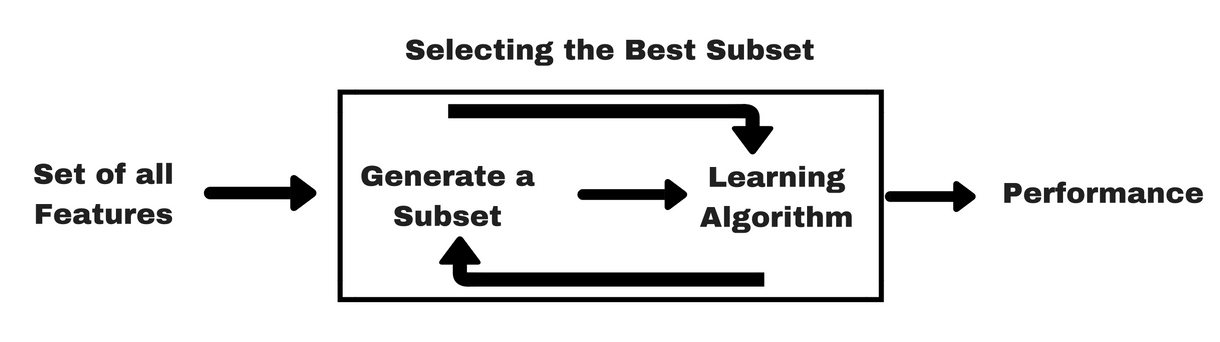


RFE is using a wrapper method, hence it is usually computationally very expensive. Some common examples of wrapper methods are forward feature selection, backward feature elimination, recursive feature elimination, etc.

* Forward Selection: Forward selection is an iterative method in which we start with having no feature in the model. In each iteration, we keep adding the feature which best improves our model till an addition of a new variable does not improve the performance of the model.
* Backward Elimination: In backward elimination, we start with all the features and removes the least significant feature at each iteration which improves the performance of the model. We repeat this until no improvement is observed on removal of features.


Instead, embedded methods that combine the qualities’ of filter and wrapper can be implemented. It’s implemented by algorithms that have their own built-in feature selection methods, e.g. lasso and ridge regression. An embedded method framework is shown below:

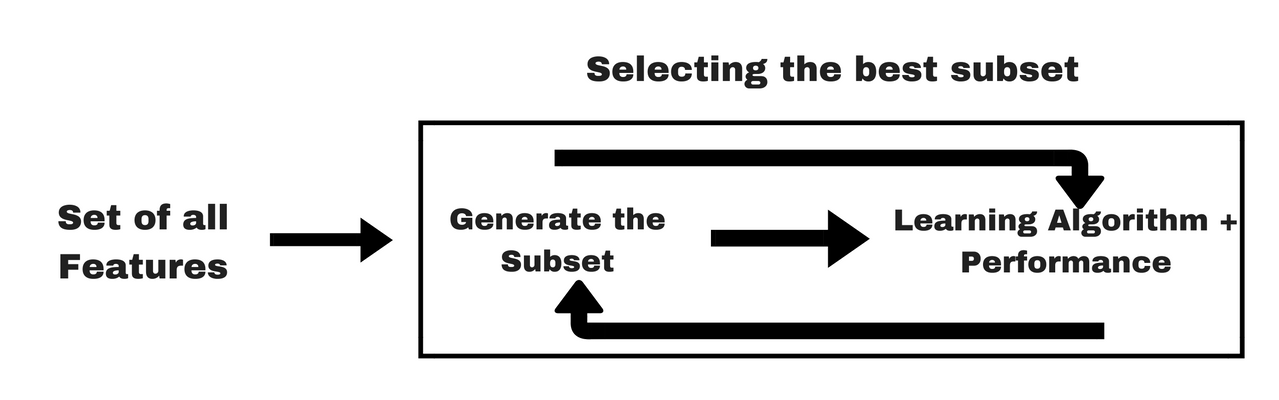


Other examples of embedded methods are Regularized trees, Memetic algorithm, Random multinomial logit.